In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm

from datetime import datetime, timedelta, tzinfo

from scipy.stats import norm, linregress, f_oneway, ttest_ind
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline import Pipeline, CustomFactor, CustomFilter
from quantopian.pipeline.factors import AverageDollarVolume, Returns

from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US

from quantopian.research import run_pipeline  

### Function definitions

In [2]:
-

### Create and run a pipeline to get assets

In [121]:
end_date = pd.Timestamp("2018-07-13")
context = {}
context["universe"] = Q3000US()

In [122]:
def make_pipeline(context):
    """
    Screen assets.
    """   
    window_length = 20
    
    open_price, high, low, close_price, volume = \
        [USEquityPricing.open, USEquityPricing.high, USEquityPricing.low, 
         USEquityPricing.close, USEquityPricing.volume]
    
    universe = context["universe"]
    
    dollar_volume_screen = AverageDollarVolume(window_length=window_length).percentile_between(70,100)
    
    mask = universe & dollar_volume_screen
    
    pipe_columns = {
            'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
            'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
            'Sector': morningstar.asset_classification.morningstar_sector_code.latest,
            'Financial Health': morningstar.asset_classification.financial_health_grade.latest,
            'Current Debt': morningstar.balance_sheet.current_debt.latest,
            'Current Assets': morningstar.balance_sheet.current_assets.latest,
            'EBITA': morningstar.income_statement.ebitda.latest,
            'Total Expenses': morningstar.income_statement.total_expenses.latest,
            'Total Revenue': morningstar.income_statement.total_revenue.latest,
            'Current Ratio': morningstar.operation_ratios.current_ratio.latest,
            'Quick Ratio': morningstar.operation_ratios.quick_ratio.latest,
            'PE': morningstar.valuation_ratios.pe_ratio.latest,
            'PEG': morningstar.valuation_ratios.peg_ratio.latest
        }
    
    pipe = Pipeline(columns=pipe_columns, screen=mask)
    return pipe

In [123]:
start_date = end_date - pd.Timedelta("1 days")

In [124]:
pipe = make_pipeline(context)
context["pipe_out"] = run_pipeline(pipe, start_date, end_date)

In [125]:
# Get the asset information from the Pipeline output.
i0 = context["pipe_out"].index.get_level_values(0)[0]
asset_information = context["pipe_out"].loc[(i0, slice(None))]

### Get Daily Data

Create a set of data with the same types that is created within the CustomFactors, so can test the user defined functions.

In [126]:
start_date = end_date - pd.Timedelta("900 days")

In [127]:
assets = context["pipe_out"].index.get_level_values(1).unique()
#assets = np.concatenate((assets, symbols(["SPY", "DIA", "QQQ"])), axis=0)
fields = ["open_price", "high", "low", "close_price", "volume"]
raw_bars = get_pricing(assets, 
                       start_date=start_date,
                       end_date=end_date,
                       frequency='daily',
                       fields=fields)

In [128]:
duplicated = raw_bars.minor_axis.duplicated()
bars = raw_bars.iloc[:, :, ~duplicated].copy()
bars = bars.dropna(axis=1, how="all", inplace=False).iloc[:, :, :]
bars = bars.dropna(axis=2, how="any", inplace=False).iloc[:, :, :]
dbars = calc_differentials(bars)

### PCA of cumulative price changes
This could be useful for seeing stocks in similar trading groups, like ETFs and used for pair trading over longer time periods.

In [129]:
def pca_analysis(df, n_components):
    X = StandardScaler().fit_transform(df)
    #X = df.apply(lambda x: (x - x.mean()) / x.std())
    pca = PCA(n_components=n_components).fit(X)
    loadings = pd.DataFrame(index=df.index, columns=range(1,n_components+1), data=pca.transform(X))
    norm_loadings = loadings.apply(lambda x: x/np.sqrt(np.dot(x, x)))
    proj = pd.DataFrame(index=range(1, n_components+1), columns=df.columns, 
                        data=np.dot(norm_loadings.T.values, df.values))
    df_model = pd.DataFrame(index=df.index, columns=df.columns, data=pca.inverse_transform(loadings))
    df_model = df_model * (df.std(axis=0)/df_model.std(axis=0)) + df.mean(axis=0)
    df_res = df - df_model
    return dict(proj=proj, model=df_model, res=df_res, expl=pca.explained_variance_ratio_, loadings=loadings)

#### PCA of daily bars

In [130]:
dbars_sub = dbars #dbars.loc[:, :, bars.volume.mean(axis=0).sort_values().tail(500).index]

In [131]:
# Calculate PCA on the price changes
items = ["cc", "oc", "co"]
n_pca_cmpts = 4

pca_proj = pd.Panel(items=items, major_axis=range(1, n_pca_cmpts+1), minor_axis=dbars_sub.minor_axis)
pca_loadings = pd.Panel(items=items, major_axis=dbars_sub.major_axis, minor_axis=range(1, n_pca_cmpts+1))
pca_model = pd.Panel(items=items, major_axis=dbars_sub.major_axis, minor_axis=dbars_sub.minor_axis)
pca_res = pd.Panel(items=items, major_axis=dbars_sub.major_axis, minor_axis=dbars_sub.minor_axis)
pca_expl = pd.DataFrame(index=range(1, n_pca_cmpts+1), columns=["cc", "oc", "co", "vol"])

pca_group_assets = pd.DataFrame(index=range(10), columns=dbars_sub.minor_axis)
P_mean_group = pd.DataFrame(index=dbars_sub.major_axis, columns=dbars_sub.minor_axis)
P_std_group = pd.DataFrame(index=dbars_sub.major_axis, columns=dbars_sub.minor_axis)

for itm in items:
    P = 100*dbars_sub.loc[itm, :, :].cumsum(axis=0)
    t = pca_analysis(P, n_pca_cmpts)
    pca_proj[itm] = t["proj"]
    pca_model[itm] = t["model"]
    pca_res[itm] = t["res"]
    pca_expl.loc[:, itm] = t["expl"]
    pca_loadings[itm] = t["loadings"]

# Use the PCA scores to estimate correlations
t = pca_proj.loc["cc"].T
corr = np.array([((t - t.iloc[i]) * (t-t.iloc[i])).sum(axis=1).values for i in range(pca_proj.shape[2])])
corr = pd.DataFrame(index=t.index, columns=t.index, data=corr)

# Calculate group statistics.
for target_asset in dbars_sub.minor_axis:
    P = 100*dbars_sub.loc["cc", :, :].cumsum(axis=0)
    group_assets = corr.loc[symbols(target_asset)].sort_values().iloc[:11].index.drop(target_asset)
    mean = P.loc[:, group_assets].mean(axis=1)
    std = P.loc[:, group_assets].std(axis=1)
    res = P.loc[:, target_asset] - mean
    pca_group_assets.loc[:, target_asset] = group_assets
    P_mean_group.loc[:, target_asset] = mean
    P_std_group.loc[:, target_asset] = std

In [132]:
cube = np.zeros((4, 3))

In [133]:
mean = pca_proj.loc["cc"].mean(axis=1)
std = pca_proj.loc["cc"].std(axis=1)

In [134]:
for i, l in enumerate([1, 2, 3, 4]):
    for j, d in enumerate([-1, 0, 1]):
        cube[i, j] = mean[l] + d*std[l]

In [135]:
# Select assets
P = 100*dbars_sub.loc["cc", :, :].cumsum(axis=0)
P_rel = (P - P_mean_group) / P_std_group
P_rel = P_rel
P_rel_cent = P_rel - P_rel.mean(axis=0)

long_pos = P_rel.columns[np.logical_and(P_rel.iloc[-1].values < -1, P_rel_cent.iloc[-1].values < -1)]
short_pos = P_rel.columns[np.logical_and(P_rel.iloc[-1].values > 1, P_rel_cent.iloc[-1].values > 1)]
print("longs: {}, shorts: {}".format(long_pos.shape[0], short_pos.shape[0]))

longs: 94, shorts: 96


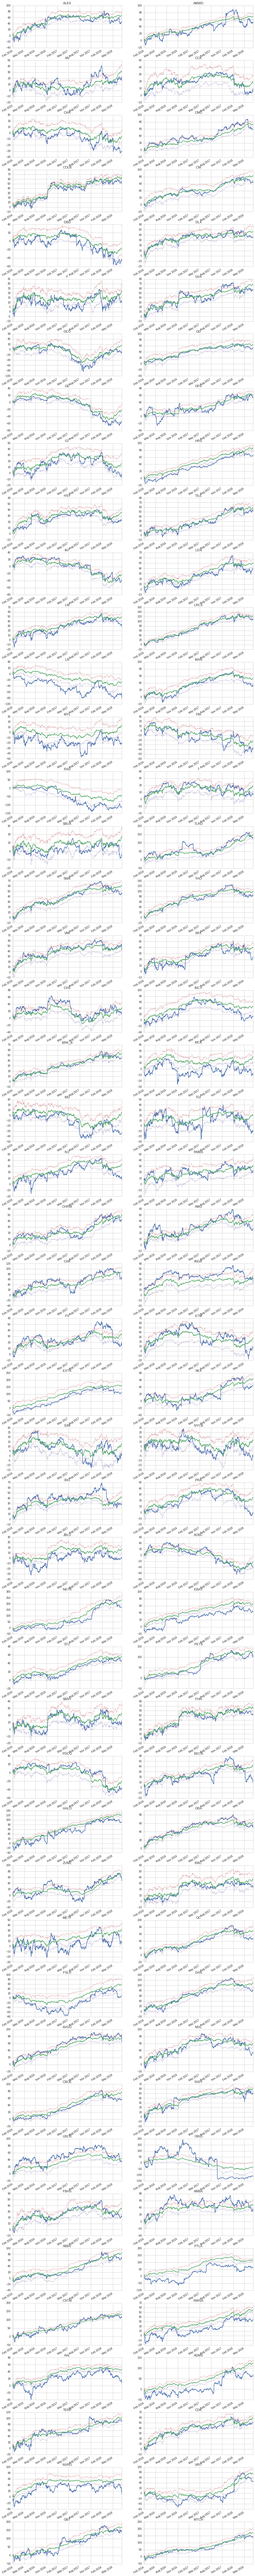

In [136]:
nrows = long_pos.shape[0]/2 + np.mod(long_pos.shape[0], 2)
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(16,4*nrows), gridspec_kw={"hspace": .3})

P = 100*dbars_sub.loc["cc", :, :].cumsum(axis=0)
for cnt, asset in enumerate(long_pos):
    i = int(cnt / 2)
    j = np.mod(cnt, 2)
    P.loc[:, asset].plot(ax=ax[i][j])
    P_mean_group.loc[:, asset].plot(ax=ax[i][j])
    (P_mean_group.loc[:, asset] + P_std_group.loc[:, asset]).plot(ax=ax[i][j], ls=":")
    (P_mean_group.loc[:, asset] - P_std_group.loc[:, asset]).plot(ax=ax[i][j], ls=":")
    ax[i][j].set_title(asset.symbol)
    #pca_group_assets[asset]

KeyError: "None of [Index([Equity(51966 [APY])], dtype='object')] are in the [columns]"

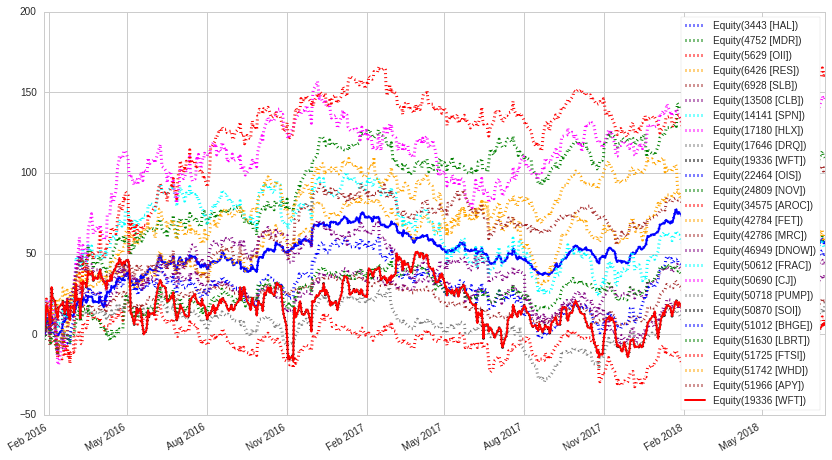

In [137]:
target_asset = symbols("hal")
group_assets = pca_group_assets.loc[:, target_asset]
t = asset_information.T
group_assets = t.loc[:, t.loc["Industry"]==t.loc["Industry", symbols("HAL")]].columns
P = 100*dbars_sub.loc["cc", :, :].cumsum(axis=0)
ax = P.loc[:, target_asset].plot(color="blue", lw=2)
colors=["blue", "green", "red", "orange", "brown", "purple", "cyan", "magenta", "gray", "black"]
P.loc[:, group_assets].plot(ax=ax, ls=":", lw=3, color=colors)
t = P.loc[:, group_assets].iloc[-1].sort_values()
low_asset = t.head(1).index
high_asset = t.tail(1).index
P.loc[:, low_asset].plot(ax=ax, ls="-", lw=2, color="red")
P.loc[:, high_asset].plot(ax=ax, ls="-", lw=2, color="green")
#ax.set_xlim(P.index[-100], P.index[-1])
#ax.set_ylim(np.min(P.loc[:, group_assets].iloc[-100:, :].values), np.max(P.loc[:, group_assets].iloc[-100:, :].values))
ax.legend(loc="upper left")

# Calculate the trail percent for trail type trades
highs = 100*dbars_sub.loc["high", (dbars_sub.loc["oc", :, target_asset] < 0).values, target_asset]
upper_trail = highs.mean() + 1*highs.std()

lows = 100*dbars_sub.loc["low", (dbars_sub.loc["oc", :, target_asset] > 0).values, target_asset]
lower_trail = lows.mean() - 1*lows.std()

print("upper trail (%): {}, lower trail (%): {}".format(upper_trail, lower_trail))
close_price = bars.loc["close_price", :, target_asset].iloc[-1]
# Override the close price if more recent data is known
upper_trail = close_price + upper_trail*.01*close_price
lower_trail = close_price + lower_trail*.01*close_price
print("upper trail ($): {}, lower trail ($): {}".format(upper_trail, lower_trail))

In [ ]:
nrows = short_pos.shape[0]/2 + np.mod(short_pos.shape[0], 2)
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(16,4*nrows), gridspec_kw={"hspace": .3})

P = 100*dbars_sub.loc["cc", :, :].cumsum(axis=0)
for cnt, asset in enumerate(short_pos):
    i = int(cnt / 2)
    j = np.mod(cnt, 2)
    P.loc[:, asset].plot(ax=ax[i][j])
    P_mean_group.loc[:, asset].plot(ax=ax[i][j])
    (P_mean_group.loc[:, asset] + P_std_group.loc[:, asset]).plot(ax=ax[i][j], ls=":")
    (P_mean_group.loc[:, asset] - P_std_group.loc[:, asset]).plot(ax=ax[i][j], ls=":")
    ax[i][j].set_title(asset.symbol)
    #pca_group_assets[asset]